In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

from keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import re
import matplotlib.image as mpimg

Using TensorFlow backend.


(171, 114, 3)


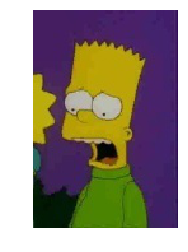

In [2]:
img=mpimg.imread("dataset/validation/bart_simpson/bart_simpson_6.jpg")
plt.imshow(img)
print(img.shape)
plt.axis('off')
plt.show()

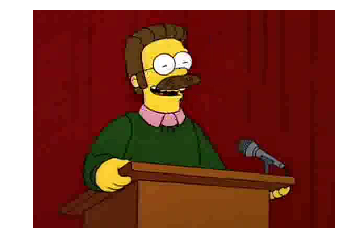

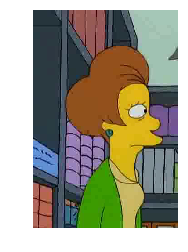

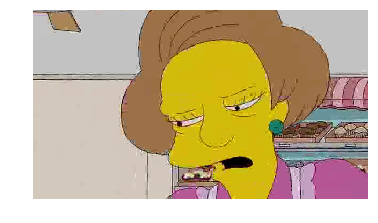

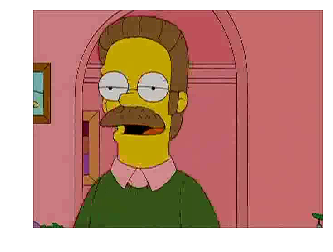

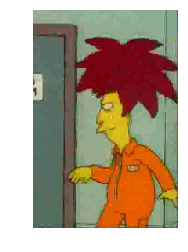

In [3]:
img_width, img_height = 224, 224

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our validation path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

files = []

for i in range(0, 5):
    path = 'dataset/train/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    img=mpimg.imread((files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [4]:
from glob import glob
classes = [i[15:-1].upper() for i in sorted(glob('dataset//train//*//'))]
print("Classes: ",classes)
num_classes = len(classes)
print("Number of classes: ",num_classes)

Classes:  ['ABRAHAM_GRAMPA_SIMPSON', 'APU_NAHASAPEEMAPETILON', 'BART_SIMPSON', 'CHARLES_MONTGOMERY_BURNS', 'CHIEF_WIGGUM', 'COMIC_BOOK_GUY', 'EDNA_KRABAPPEL', 'HOMER_SIMPSON', 'KENT_BROCKMAN', 'KRUSTY_THE_CLOWN', 'LENNY_LEONARD', 'LISA_SIMPSON', 'MARGE_SIMPSON', 'MAYOR_QUIMBY', 'MILHOUSE_VAN_HOUTEN', 'MOE_SZYSLAK', 'NED_FLANDERS', 'NELSON_MUNTZ', 'PRINCIPAL_SKINNER', 'SIDESHOW_BOB']
Number of classes:  20


## preprocessing

In [5]:
img_rows, img_cols = 64, 64
batch_size = 64

train_data_dir = './dataset/train'
validation_data_dir = './dataset/validation'

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.3, height_shift_range=0.3,
                                  horizontal_flip=True, fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size,
                                                   class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols), 
                                                              batch_size=batch_size, class_mode='categorical')

Found 19548 images belonging to 20 classes.
Found 990 images belonging to 20 classes.


In [6]:
from keras.layers import BatchNormalization

model = Sequential()

# First CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape = (img_rows, img_cols, 3)))
model.add(BatchNormalization())

# Second CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (img_rows, img_cols, 3)))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# First set of FC or Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second set of FC or Dense Layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final Dense Layer
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [71]:
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("trained_model/simpsons_adam1.h5", monitor='val_loss', mode='min', save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.00001)

callbacks = [earlystop, checkpoint, reduce_lr]

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

nb_train_samples = 19548
nb_validation_samples = 990
epochs = 15

hist = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, callbacks=callbacks,
                          validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size)

Epoch 1/15
305/305 [==============================] - 74s 243ms/step - loss: 0.5538 - acc: 0.8483 - val_loss: 0.3394 - val_acc: 0.9006

Epoch 00001: val_loss improved from inf to 0.33938, saving model to trained_model/simpsons_adam1.h5
Epoch 2/15
305/305 [==============================] - 72s 236ms/step - loss: 0.5002 - acc: 0.8615 - val_loss: 0.3693 - val_acc: 0.8979

Epoch 00002: val_loss did not improve from 0.33938
Epoch 3/15
305/305 [==============================] - 73s 238ms/step - loss: 0.4923 - acc: 0.8637 - val_loss: 0.3785 - val_acc: 0.8855

Epoch 00003: val_loss did not improve from 0.33938
Epoch 4/15
305/305 [==============================] - 73s 239ms/step - loss: 0.4777 - acc: 0.8673 - val_loss: 0.3631 - val_acc: 0.8942

Epoch 00004: val_loss did not improve from 0.33938

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 5/15
305/305 [==============================] - 72s 237ms/step - loss: 0.3763 - acc: 0.8937 - val_loss: 0.1584 - val

Found 990 images belonging to 20 classes.
Confusion Matrix
[[24  0  1  0  0  0  0 19  0  0  0  3  1  0  0  0  0  0  0  0]
 [ 0 46  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 42  0  0  0  0  0  0  0  0  7  1  0  0  0  0  0  0  0]
 [ 0  0  0 34  3  0  0  0  1  0  0  3  0  3  0  3  0  0  0  1]
 [ 0  0  0  0 48  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  1 12 25  0  0  0  0  0  1  0  3  0  3  2  1  0  1]
 [ 0  0  6  2  2  0 31  0  1  0  1  5  1  0  0  0  0  1  0  0]
 [ 0  0  2  0  0  0  0 45  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  1  0  0  0 47  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  7  0  0  1  1 34  0  2  0  0  1  0  0  0  0  3]
 [ 0  0  0  0  2  0  0  4  0  0 42  0  0  0  0  0  0  0  0  2]
 [ 0  0  7  0  1  0  0  1  0  0  0 40  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 48  0  0  1  0  0  0  1]
 [ 0  0  0  0  3  0  0  0  1  0  0  0  0 41  0  3  0  2  0  0]
 [ 0  0  0  0  1  0  0  1  0  0  0  0  0  0 46  1  0  0  0 

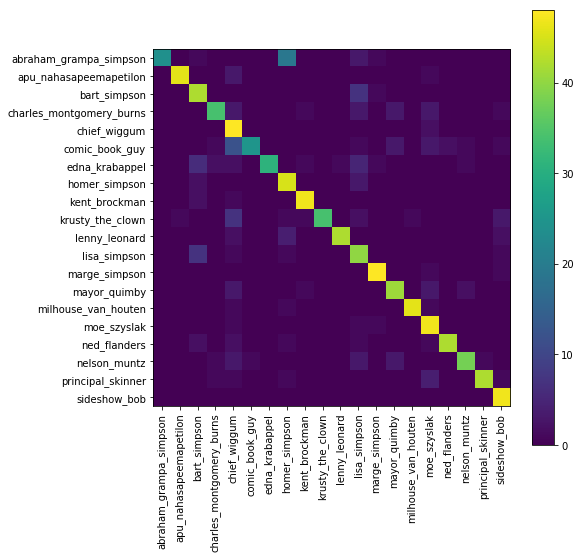

In [64]:
# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=batch_size, class_mode='categorical', shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 19548
nb_validation_samples = 990

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [7]:
m1 = load_model('trained_model/simpsons_rmsprop1.h5')

In [8]:
m2 = load_model('trained_model/simpsons_adam1.h5')

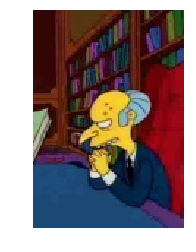

Predicted(RMSProp):  charles_montgomery_burns
Predicted(Adam):  charles_montgomery_burns
True:  charles_montgomery_burns

------------------------------------------------


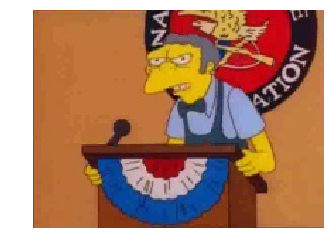

Predicted(RMSProp):  moe_szyslak
Predicted(Adam):  moe_szyslak
True:  moe_szyslak

------------------------------------------------


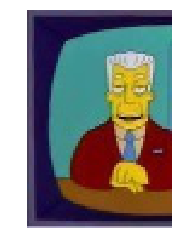

Predicted(RMSProp):  kent_brockman
Predicted(Adam):  kent_brockman
True:  kent_brockman

------------------------------------------------


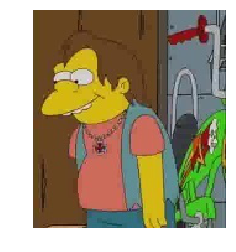

Predicted(RMSProp):  nelson_muntz
Predicted(Adam):  nelson_muntz
True:  nelson_muntz

------------------------------------------------


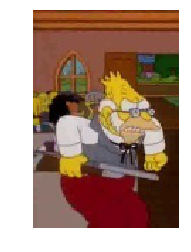

Predicted(RMSProp):  homer_simpson
Predicted(Adam):  abraham_grampa_simpson
True:  abraham_grampa_simpson

------------------------------------------------


In [10]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

# checking model on validation data
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our validation path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 64, 64

files = []
predictions1 = []
predictions2 = []
true_labels = []

# predicting images
for i in range(0, 5):
    path = 'dataset/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes1 = np.argmax(m1.predict(images, batch_size=10))
    classes2 = np.argmax(m2.predict(images, batch_size=10))
    predictions1.append(classes1)
    predictions2.append(classes2)
    
for i in range(0, len(files)):
    img=mpimg.imread((files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Predicted(RMSProp): ",class_labels[predictions1[i]])
    print("Predicted(Adam): ",class_labels[predictions2[i]])
    print("True: ",true_labels[i])
    print("\n------------------------------------------------")

In [17]:
def check_1(path):
    img=mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # prediction
    img = image.load_img(path, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x.astype('float32')/255
    pred1 = np.argmax(m1.predict(x))
    pred2 = np.argmax(m2.predict(x))
    print("(RMSprop)It's a {}.".format(class_labels[pred1])) 
    print("(Adam)It's a {}.".format(class_labels[pred2])) 

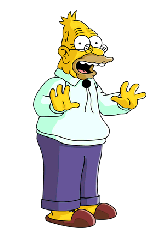

(RMSprop)It's a homer_simpson.
(Adam)It's a homer_simpson.


In [18]:
check_1('check/grampa.png')

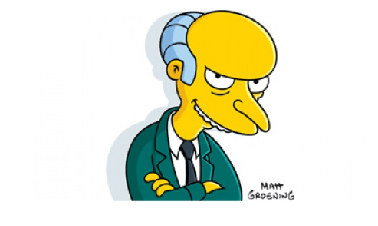

(RMSprop)It's a charles_montgomery_burns.
(Adam)It's a charles_montgomery_burns.


In [19]:
check_1('check/Charles-Montgomery-Burns.jpg')

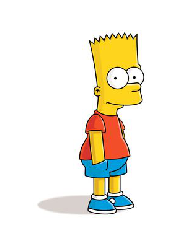

(RMSprop)It's a lisa_simpson.
(Adam)It's a bart_simpson.


In [21]:
check_1('check/bart-simpson.jpg')

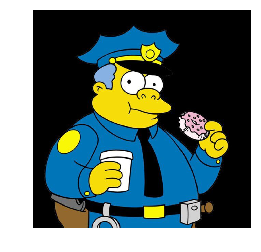

(RMSprop)It's a chief_wiggum.
(Adam)It's a chief_wiggum.


In [22]:
check_1('check/chief.jpeg')

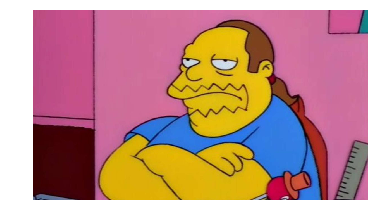

(RMSprop)It's a comic_book_guy.
(Adam)It's a comic_book_guy.


In [23]:
check_1('check/comic.jpg')

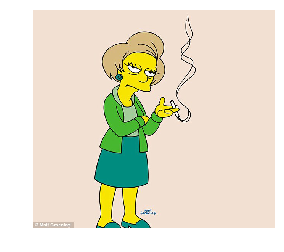

(RMSprop)It's a homer_simpson.
(Adam)It's a edna_krabappel.


In [24]:
check_1('check/edna.jpg')

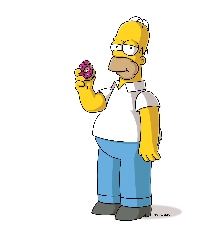

(RMSprop)It's a homer_simpson.
(Adam)It's a homer_simpson.


In [25]:
check_1('check/homer.jpg')

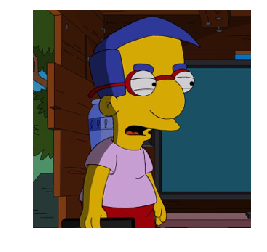

(RMSprop)It's a milhouse_van_houten.
(Adam)It's a milhouse_van_houten.


In [28]:
check_1('check/van.jpg')

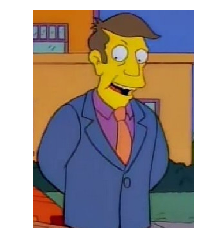

(RMSprop)It's a principal_skinner.
(Adam)It's a principal_skinner.


In [29]:
check_1('check/Principal_Skinner.jpg')

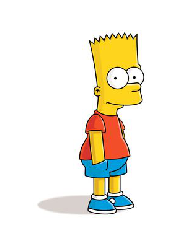

Predicted(RMSProp):  lisa_simpson
Predicted(Adam):  bart_simpson
True:  Bart Simpson

------------------------------------------------


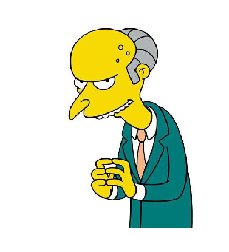

Predicted(RMSProp):  charles_montgomery_burns
Predicted(Adam):  charles_montgomery_burns
True:  CHARLES_MONTGOMERY_BURNS

------------------------------------------------


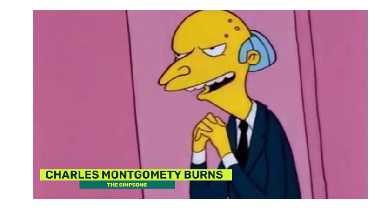

Predicted(RMSProp):  charles_montgomery_burns
Predicted(Adam):  charles_montgomery_burns
True:  CHARLES_MONTGOMERY_BURNS

------------------------------------------------


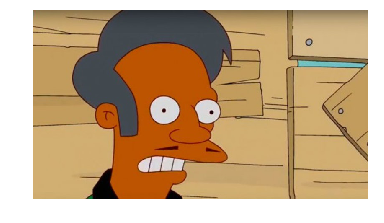

Predicted(RMSProp):  apu_nahasapeemapetilon
Predicted(Adam):  apu_nahasapeemapetilon
True:  APU_NAHASAPEEMAPETILON

------------------------------------------------


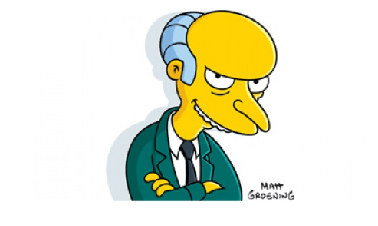

Predicted(RMSProp):  charles_montgomery_burns
Predicted(Adam):  charles_montgomery_burns
True:  CHARLES_MONTGOMERY_BURNS

------------------------------------------------


In [51]:
# checking model on test data
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 64, 64

files = []
predictions1 = []
predictions2 = []
true_labels = []

# predicting images
for i in range(0, 5):
    path = 'dataset/check/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes1 = np.argmax(m1.predict(images, batch_size=10))
    classes2 = np.argmax(m2.predict(images, batch_size=10))
    predictions1.append(classes1)
    predictions2.append(classes2)
    
for i in range(0, len(files)):
    img=mpimg.imread((files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Predicted(RMSProp): ",class_labels[predictions1[i]])
    print("Predicted(Adam): ",class_labels[predictions2[i]])
    print("True: ",true_labels[i])
    print("\n------------------------------------------------")